Modify the KNN scratch code in our lecture such that:
- If the majority class of the first place is equal to the second place, then ask the algorithm to pick the next nearest neighbors as the decider
- Modify the code so it outputs the probability of the decision, where the probability is simply the class probability based on all the nearest neighbors
- Write a function which allows the program to receive a range of k, and output the cross validation score.  Last, it shall inform us which k is the best to use from a predefined range
- Put everything into a class <code>KNN(k=3)</code>.  It should have at least one method, <code>predict(X_train, X_test, y_train)</code>

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X, y = make_blobs(n_samples=300, centers=4, random_state=0, cluster_std=1.0)

#standardize
scaler = StandardScaler()
X = scaler.fit_transform(X)

#do train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [2]:
def find_distance(X_train, X_test):
    #create newaxis simply so that broadcast to all values
    dist = X_test[:, np.newaxis, :] - X_train[np.newaxis, :, :]
    sq_dist = dist ** 2
    
    #sum across feature dimension, thus axis = 2
    summed_dist = sq_dist.sum(axis=2)
    sq_dist = np.sqrt(summed_dist)
    return sq_dist

def find_neighbors(X_train, X_test, k=3):
    dist = find_distance(X_train, X_test)
    #return the first k neighbors
    neighbors_ix = np.argsort(dist)[:, 0:k]
    return neighbors_ix

def get_most_common(y):
    return np.bincount(y).argmax()

In [3]:
def predict(X_train, X_test, y_train, k=3):
    classes = len(np.unique(y_train))
    neighbors_ix = find_neighbors(X_train, X_test, k)

    pred = np.zeros(X_test.shape[0])
    prob = np.zeros((X_test.shape[0],classes))
    for ix, y in enumerate(y_train[neighbors_ix]):
        freq = np.bincount(y)
        while len(freq) < classes:
            freq = np.append(freq, 0)
        k_inc = k
        while np.sort(freq)[-1] == np.sort(freq)[-2]:
            k_inc += 1
            neighbors_ix_new = find_neighbors(X_train, X_test[ix].reshape(1,-1), k_inc).reshape(-1)
            freq = np.bincount(y_train[neighbors_ix_new])
            while len(freq) < classes:
                freq = np.append(freq, 0)
        prob[ix] = freq/np.sum(freq)
        pred[ix] = get_most_common(y)
    return pred, prob

In [4]:
yhat, yhat_prob = predict(X_train, X_test, y_train, k=5)

In [5]:
print("Accuracy: ", np.sum(yhat == y_test)/len(y_test))

Accuracy:  0.9222222222222223


In [6]:
print("Class", "\t", "Probability")
for idx, prop in enumerate(yhat_prob[:51]):
    print(idx, "\t", prop)

Class 	 Probability
0 	 [0. 0. 0. 1.]
1 	 [0. 1. 0. 0.]
2 	 [1. 0. 0. 0.]
3 	 [1. 0. 0. 0.]
4 	 [0. 1. 0. 0.]
5 	 [0. 0. 1. 0.]
6 	 [0.2 0.8 0.  0. ]
7 	 [0. 0. 1. 0.]
8 	 [0. 1. 0. 0.]
9 	 [0. 1. 0. 0.]
10 	 [0.8 0.2 0.  0. ]
11 	 [0.2 0.  0.8 0. ]
12 	 [0. 0. 1. 0.]
13 	 [0. 0. 0. 1.]
14 	 [0.2 0.  0.8 0. ]
15 	 [0. 1. 0. 0.]
16 	 [0. 0. 0. 1.]
17 	 [0.8 0.  0.  0.2]
18 	 [0. 0. 0. 1.]
19 	 [0.4 0.  0.6 0. ]
20 	 [1. 0. 0. 0.]
21 	 [0. 0. 1. 0.]
22 	 [0. 0. 1. 0.]
23 	 [1. 0. 0. 0.]
24 	 [0. 1. 0. 0.]
25 	 [0. 0. 1. 0.]
26 	 [1. 0. 0. 0.]
27 	 [0.6 0.  0.4 0. ]
28 	 [0. 0. 0. 1.]
29 	 [0.8 0.  0.  0.2]
30 	 [0.2 0.  0.  0.8]
31 	 [0. 0. 1. 0.]
32 	 [1. 0. 0. 0.]
33 	 [0. 1. 0. 0.]
34 	 [0. 1. 0. 0.]
35 	 [0. 0. 0. 1.]
36 	 [1. 0. 0. 0.]
37 	 [1. 0. 0. 0.]
38 	 [0. 1. 0. 0.]
39 	 [0. 1. 0. 0.]
40 	 [0. 1. 0. 0.]
41 	 [0. 0. 0. 1.]
42 	 [0. 0. 1. 0.]
43 	 [0.4 0.6 0.  0. ]
44 	 [1. 0. 0. 0.]
45 	 [0. 1. 0. 0.]
46 	 [0.8 0.  0.  0.2]
47 	 [0.8 0.  0.2 0. ]
48 	 [1. 0. 0. 0.]
49 	 [1. 0.

In [7]:
def CV_K(X_train_val, y_train_val, K_max=5, cv=3):
    # Split train data and validation data
    m, n = X_train_val.shape
    idx = list(range(m))
    idx_List = []
    for i in range(cv):
        idx_List.append(idx[i*int(m/cv):(i+1)*int(m/cv)])
    # Predict and find accuracy
    acc = []
    K = []
    for i in range(1, K_max+1):
        acc_sum = 0
        for idx in idx_List:
            X_val = X_train_val[idx]
            y_val = y_train_val[idx]
            X_train = np.delete(X_train_val,idx, axis=0)
            y_train = np.delete(y_train_val,idx, axis=0)
            yhat, yhat_prob = predict(X_train, X_val, y_train, k=i)
            acc_sum += np.sum(yhat == y_val)/len(y_val)
        acc.append(acc_sum/cv)
        K.append(i)
    return acc, K

Best K: 7 Accuracy: 0.938095238095238


<function matplotlib.pyplot.show(close=None, block=None)>

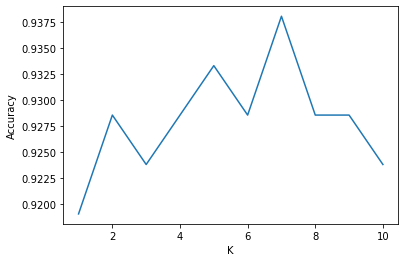

In [8]:
acc, K = CV_K(X_train, y_train, K_max=10, cv=5)
idx = np.argmax(acc)
print("Best K:", K[idx], "Accuracy:",acc[idx])
plt.plot(K, acc)
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.show

In [9]:
class KNN:
    def predict(self, X_train, X_test, y_train, k=3):
        classes = len(np.unique(y_train))
        neighbors_ix = self.find_neighbors(X_train, X_test, k)

        pred = np.zeros(X_test.shape[0])
        prob = np.zeros((X_test.shape[0],classes))
        for ix, y in enumerate(y_train[neighbors_ix]):
            freq = np.bincount(y)
            while len(freq) < classes:
                freq = np.append(freq, 0)
            k_inc = k
            while np.sort(freq)[-1] == np.sort(freq)[-2]:
                k_inc += 1
                neighbors_ix_new = self.find_neighbors(X_train, X_test[ix].reshape(1,-1), k_inc).reshape(-1)
                freq = np.bincount(y_train[neighbors_ix_new])
                while len(freq) < classes:
                    freq = np.append(freq, 0)
            prob[ix] = freq/np.sum(freq)
            pred[ix] = get_most_common(y)
        return pred, prob

    def find_distance(self, X_train, X_test):
        #create newaxis simply so that broadcast to all values
        dist = X_test[:, np.newaxis, :] - X_train[np.newaxis, :, :]
        sq_dist = dist ** 2

        #sum across feature dimension, thus axis = 2
        summed_dist = sq_dist.sum(axis=2)
        sq_dist = np.sqrt(summed_dist)
        return sq_dist

    def find_neighbors(self, X_train, X_test, k=3):
        dist = find_distance(X_train, X_test)
        #return the first k neighbors
        neighbors_ix = np.argsort(dist)[:, 0:k]
        return neighbors_ix

    def get_most_common(self, y):
        return np.bincount(y).argmax()

In [14]:
model = KNN()
yhat, yhat_prob = model.predict(X_train, X_test, y_train, k=7)
print("Accuracy: ", np.sum(yhat == y_test)/len(y_test))

Accuracy:  0.9222222222222223
